In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [3]:
cd '/content/drive/MyDrive/Colab Notebooks/ODL'

/content/drive/MyDrive/Colab Notebooks/ODL


# Import Libraries

In [4]:
import os, sys, json, cv2, time, glob, gc, datetime, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.patches as patches
import seaborn as sns; sns.set(font_scale=1.4)
import keras_tuner as kt
import warnings

from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Reshape, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, precision_recall_curve, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from kerastuner import HyperModel, Hyperband
from kerastuner.tuners import RandomSearch
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

<ipython-input-4-d196fd78da00>:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, Hyperband


# Configurations

In [5]:
CSV_PATH = './df.csv'
ARR_PATH = './natural_scene_data.npz'
SAVE_PATH = 'models/CustomCNN/'
CHECKPOINT_DIR = 'models/CustomCNN/checkpoints/'

EPOCHS = 50
IMAGE_SIZE = (150, 150)
IMG_SIZE = 150
BATCH_SIZE = 32
N_CLASSES = 6

N_TRIALS = 10
N_ROWS = None # Number of rows in the dataset
# TRAIN_LEN = 5000
# VAL_LEN = 1000
# TEST_LEN = 1000
# TRAIN_LEN = 10
# VAL_LEN = 10
# TEST_LEN = 10

# Create a directory if it doesn't exist
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)
if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

# Check if a GPU is available and set the device
if tf.config.experimental.list_physical_devices('GPU'):
    device = '/GPU:0'
    print("GPU is available")
else:
    device = '/CPU:0'
    print("GPU is not available, using CPU")

GPU is not available, using CPU


# Data Loading

In [ ]:
df = pd.read_csv(CSV_PATH)
df.head()

Image  Label Label_names  Split
0  [[[0.24313726 0.28235295 0.38039216]\n  [0.101...      1      street  train
1  [[[0.8117647  0.8117647  0.85882354]\n  [0.796...      3   buildings  train
2  [[[0.18431373 0.1764706  0.09411765]\n  [0.337...      1      street  train
3  [[[0.3647059  0.4627451  0.72156864]\n  [0.368...      0    mountain    val
4  [[[0.2509804  0.3254902  0.21568628]\n  [0.137...      5      forest  train

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17034 entries, 0 to 17033
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Image        17034 non-null  object
 1   Label        17034 non-null  int64 
 2   Label_names  17034 non-null  object
 3   Split        17034 non-null  object
dtypes: int64(1), object(3)
memory usage: 532.4+ KB


In [ ]:
data = np.load(ARR_PATH, allow_pickle=True)
X_train, X_val, Y_train, Y_val, X_test, labels_dict = data['X_train'], data['X_val'], data['Y_train'], data['Y_val'], data['X_test'], data['labels_dict']
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape, X_test.shape)
labels_dict

(14034, 150, 150, 3) (3000, 150, 150, 3) (14034,) (3000,) (7301, 150, 150, 3)


array({'mountain': 0, 'street': 1, 'glacier': 2, 'buildings': 3, 'sea': 4, 'forest': 5},
      dtype=object)

In [ ]:
labels_dict = labels_dict.tolist()
labels_dict = {v: k for k, v in labels_dict.items()}
labels_dict

{0: 'mountain',
 1: 'street',
 2: 'glacier',
 3: 'buildings',
 4: 'sea',
 5: 'forest'}

In [ ]:
if N_ROWS:
    X_train = X_train[:N_ROWS]
    Y_train = Y_train[:N_ROWS]
    X_val = X_val[:N_ROWS]
    Y_val = Y_val[:N_ROWS]
    X_test = X_test[:N_ROWS]
    EPOCHS = 2

In [ ]:
# Convert Y_train to one-hot encoded format
Y_train_one_hot = to_categorical(Y_train)
Y_val_one_hot = to_categorical(Y_val)
Y_train_one_hot.shape, Y_val_one_hot.shape

((14034, 6), (3000, 6))

In [ ]:
# Define a function to apply random transformations to images
def random_transform(image, label):
    image = tf.image.random_flip_left_right(image)  # Randomly flip the image horizontally
    image = tf.image.random_flip_up_down(image)  # Randomly flip the image vertically
    image = tf.image.random_brightness(image, max_delta=0.1)  # Randomly change the brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Randomly change the contrast
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)  # Randomly change the saturation
    image = tf.image.random_hue(image, max_delta=0.1)  # Randomly change the hue
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Randomly rotate the image
    image = tf.image.random_crop(image, size=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])  # Randomly crop the image

    # Random zoom
    scales = list(np.arange(0.8, 1.0, 0.1))
    boxes = np.zeros((len(scales), 4))
    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[i] = [x1, y1, x2, y2]

    def random_zoom(image):
        crops = tf.image.crop_and_resize([image], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=IMAGE_SIZE)
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    image = random_zoom(image)

    # Random Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    image = tf.add(image, noise)

    return image, label

# Function to cast images and labels to float16
def cast_to_float16(image, label):
    image = tf.cast(image, tf.float16)
    label = tf.cast(label, tf.float16)
    return image, label

def create_dataset(X, Y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.map(random_transform, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(cast_to_float16, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset


In [ ]:
del Y_train, Y_val, data
gc.collect()
# X_train = X_train[:TRAIN_LEN]
# Y_train_one_hot = Y_train_one_hot[:TRAIN_LEN]
# X_val = X_val[:VAL_LEN]
# Y_val_one_hot = Y_val_one_hot[:VAL_LEN]
# X_test = X_test[:TEST_LEN]

2635

In [ ]:
# Create a tf.data.Dataset from X_train and Y_train
# train_dataset = create_dataset(X_train, Y_train, batch_size=BATCH_SIZE)
train_dataset = create_dataset(X_train, Y_train_one_hot, batch_size=BATCH_SIZE)

# Create a tf.data.Dataset from X_val and Y_val
# val_dataset = create_dataset(X_val, Y_val, batch_size=BATCH_SIZE)
val_dataset = create_dataset(X_val, Y_val_one_hot, batch_size=BATCH_SIZE)

# Create a tf.data.Dataset from X_test
test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_dataset = test_dataset.batch(BATCH_SIZE)  # Batch the dataset
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)  # Prefetch for performance

# Print the dataset shapes to verify
for images, labels in train_dataset.take(1):
    print(images.shape, labels.shape)

for images, labels in val_dataset.take(1):
    print(images.shape, labels.shape)

for images in test_dataset.take(1):
    print(images.shape)

(32, 150, 150, 3) (32, 6)
(32, 150, 150, 3) (32, 6)
(32, 150, 150, 3)


In [ ]:
def plot_metrics(history, model, val_dataset=val_dataset, labels_dict=labels_dict):
    # Extract metrics from the history object
    metrics = {
        'loss': history.history.get('loss', []),
        'val_loss': history.history.get('val_loss', []),
        'precision': history.history.get('precision', []),
        'val_precision': history.history.get('val_precision', []),
        'recall': history.history.get('recall', []),
        'val_recall': history.history.get('val_recall', []),
        'auc': history.history.get('auc', []),
        'val_auc': history.history.get('val_auc', []),
        'lr': history.history.get('learning_rate', []),
        'accuracy': history.history.get('accuracy', []),
        'val_accuracy': history.history.get('val_accuracy', [])
    }

    # Calculate F1-score for each epoch (if precision and recall are available)
    metrics['f1_score'] = [2 * ((p * r) / (p + r + 1e-7)) if (p + r) > 0 else 0
                           for p, r in zip(metrics['precision'], metrics['recall'])]
    metrics['val_f1_score'] = [2 * ((p * r) / (p + r + 1e-7)) if (p + r) > 0 else 0
                               for p, r in zip(metrics['val_precision'], metrics['val_recall'])]

    epochs = range(1, len(metrics['loss']) + 1)

    plt.figure(figsize=(33, 22))

    # Plot Loss
    plt.subplot(3, 3, 1)
    plt.plot(metrics['loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot Accuracy
    plt.subplot(3, 3, 2)
    plt.plot(metrics['accuracy'], label='Train Accuracy')
    plt.plot(metrics['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot Precision
    plt.subplot(3, 3, 3)
    plt.plot(metrics['precision'], label='Train Precision')
    plt.plot(metrics['val_precision'], label='Val Precision')
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot Recall
    plt.subplot(3, 3, 4)
    plt.plot(metrics['recall'], label='Train Recall')
    plt.plot(metrics['val_recall'], label='Val Recall')
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot F1-score
    plt.subplot(3, 3, 5)
    plt.plot(metrics['f1_score'], label='Train F1-Score')
    plt.plot(metrics['val_f1_score'], label='Val F1-Score')
    plt.title('Model F1-Score')
    plt.ylabel('F1-Score')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot AUC
    plt.subplot(3, 3, 6)
    plt.plot(metrics['auc'], label='Train AUC')
    plt.plot(metrics['val_auc'], label='Val AUC')
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot learning rate
    plt.subplot(3, 3, 7)
    plt.plot(metrics['lr'], label='Learning Rate')
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    result = model.get_val_info(val_dataset)
    y_true, y_pred_prob = result['y_true'], result['y_pred_prob']

    # ROC Curve for each class
    num_classes = y_pred_prob.shape[1]
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.subplot(3, 3, 8)
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} {labels_dict[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve for Each Class')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Precision-Recall Curve for each class
    plt.subplot(3, 3, 9)
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true == i, y_pred_prob[:, i])
        plt.plot(recall, precision, label=f'Class {i} {labels_dict[i]}')
    plt.title('Precision-Recall Curve for Each Class')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

# Custom CNN

In [ ]:
class CustomCNNModel:
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=N_CLASSES):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = Sequential()

        # First Convolutional Block
        model.add(Conv2D(128, (3, 3), strides=(1, 1), input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(128, (3, 3), strides=(1, 1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        # Second Convolutional Block
        model.add(Conv2D(256, (3, 3), strides=(1, 1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(256, (3, 3), strides=(1, 1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        # Third Convolutional Block
        model.add(Conv2D(512, (3, 3), strides=(1, 1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(512, (3, 3), strides=(1, 1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        # Global Average Pooling instead of Flattening
        model.add(GlobalAveragePooling2D())

        # Fully Connected Layer with Dropout
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu'))

        # Output Layer for classification
        model.add(Dense(self.num_classes, activation='softmax'))  # Output layer with num_classes units
        return model

    def compile_model(self):
        self.model.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=[
                               'accuracy',  # Built-in accuracy for sparse labels
                                tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall'),
                                tf.keras.metrics.AUC(name='auc', multi_label=True),  # AUC for multiclass
                  ])

    def train(self, train_dataset=train_dataset, val_dataset=val_dataset, epochs=EPOCHS, checkpoint_dir=CHECKPOINT_DIR):
        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
        checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir, 'custom_cnn_model.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
        log_dir = os.path.join('logs', 'CustomCNN', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

        history = self.model.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                                 callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback])
        return history

    def validation(self, val_dataset=val_dataset):
        results = self.model.evaluate(val_dataset)
        loss, accuracy, precision, recall, auc = results
        print(f'Testing Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}')
        return {
            'loss': loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'auc': auc
        }

    def get_val_info(self, val_dataset=val_dataset):
        # Get true labels and predicted probabilities
        y_true = []
        y_pred_prob = []

        # Iterate through validation dataset and collect true labels and predicted probabilities
        for batch in val_dataset:
            x_val, y_val = batch  # x_val: validation features, y_val: validation true labels
            y_true.extend(y_val.numpy())  # Collect true labels

            # Predict the probabilities for each class
            preds = self.model.predict(x_val)
            y_pred_prob.extend(preds)

        # Convert lists to numpy arrays
        y_true = np.array(y_true)
        y_true = np.argmax(y_true, axis=-1)  # Convert one-hot encoded labels to categorical labels
        y_pred_prob = np.array(y_pred_prob)

        return {
            'y_true': y_true,  # Return true labels
            'y_pred_prob': y_pred_prob  # Return predicted probabilities
        }

    def predict_batch(self, test_dataset=test_dataset, labels_dict=labels_dict):
        predictions = self.model.predict(test_dataset)
        predictions = tf.argmax(predictions, axis=-1)
        predictions = np.vectorize(labels_dict.get)(predictions)
        return predictions

    def predict_single(self, image, labels_dict=labels_dict):
        # Image shape should be (150, 150, 3)
        result = self.model.predict(np.expand_dims(image, axis=0))
        result = np.array(result)[0]
        result = labels_dict[result]
        return result

    def save(self, path):
        self.model.save(path)

In [ ]:
# Initialize the CustomCNNModel class
custom_cnn_model = CustomCNNModel()

# Compile the model
custom_cnn_model.compile_model()

# Print the model summary
custom_cnn_model.model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 148, 148, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 146, 146, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 146, 146, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 73, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 73, 73, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 71, 71, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 71, 71, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 69, 69, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 69, 69, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 69, 69, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 32, 32, 512)         │              

 Total params: 5,636,742 (21.50 MB)

 Trainable params: 5,633,158 (21.49 MB)

 Non-trainable params: 3,584 (14.00 KB)

# Training

In [ ]:
# Train the model
history = custom_cnn_model.train()

Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 87s 124ms/step - accuracy: 0.4133 - auc: 0.7688 - loss: 1.4494 - precision: 0.5789 - recall: 0.1840 - val_accuracy: 0.3683 - val_auc: 0.8152 - val_loss: 1.6102 - val_precision: 0.4364 - val_recall: 0.1533 - learning_rate: 0.0010
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.5667 - auc: 0.8687 - loss: 1.1045 - precision: 0.6745 - recall: 0.3934 - val_accuracy: 0.3870 - val_auc: 0.8151 - val_loss: 1.8214 - val_precision: 0.4240 - val_recall: 0.3293 - learning_rate: 0.0010
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.6156 - auc: 0.8925 - loss: 0.9939 - precision: 0.7096 - recall: 0.4769 - val_accuracy: 0.6247 - val_auc: 0.9067 - val_loss: 0.9840 - val_precision: 0.6998 - val_recall: 0.4973 - learning_rate: 0.0010
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.6351 - auc: 0.9052 - loss: 0.9382 - precision: 0.7141 - recall: 0.5239 - val_accuracy: 0.6443 - val_auc: 0.9214 - val_loss: 0.9

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

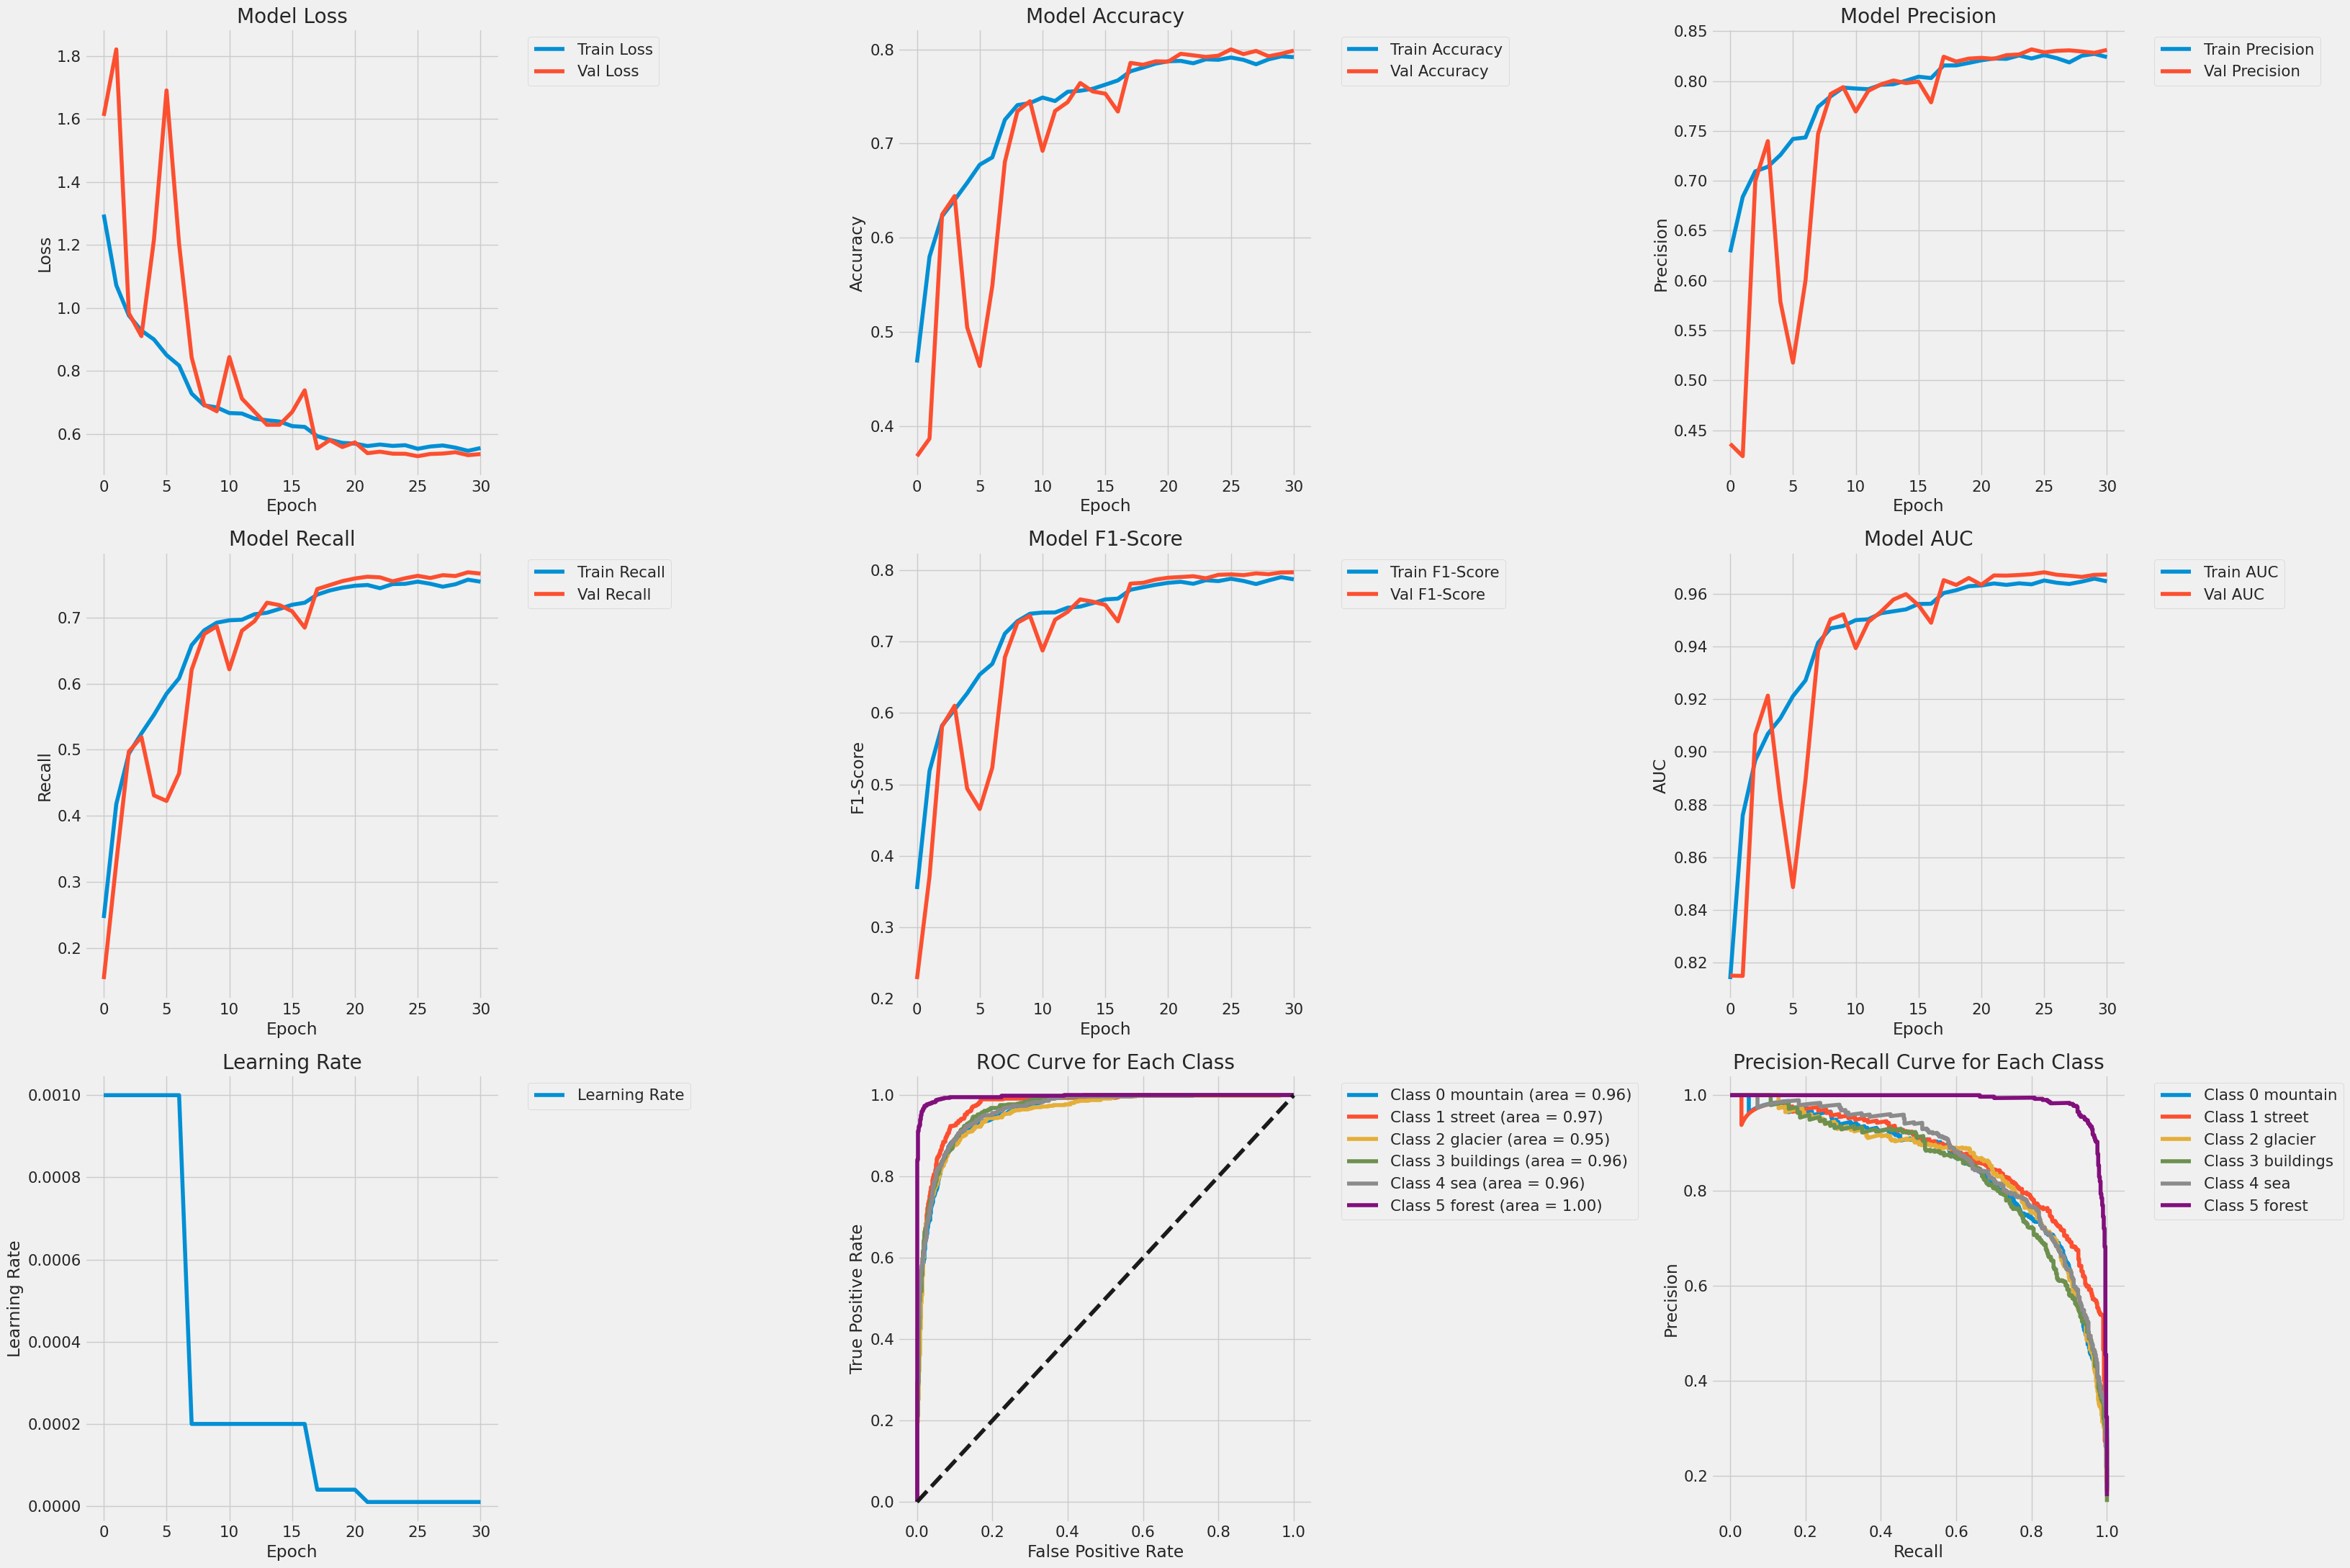

In [ ]:
plot_metrics(history, model=custom_cnn_model, val_dataset=val_dataset, labels_dict=labels_dict)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

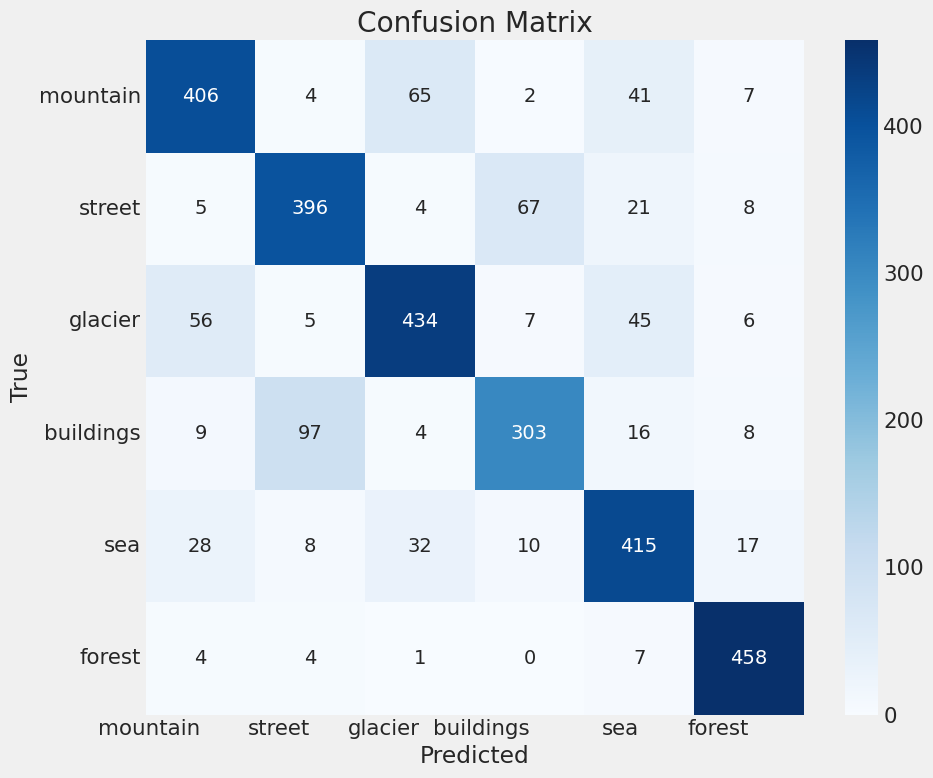

Classification Report:
              precision    recall  f1-score   support

    mountain       0.80      0.77      0.79       525
      street       0.77      0.79      0.78       501
     glacier       0.80      0.78      0.79       553
   buildings       0.78      0.69      0.73       437
         sea       0.76      0.81      0.79       510
      forest       0.91      0.97      0.94       474

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000



In [ ]:
# Get validation information
result = custom_cnn_model.get_val_info(val_dataset)
y_true, y_pred_prob = result['y_true'], result['y_pred_prob']
y_pred = np.argmax(y_pred_prob, axis=1)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))  # Increase the figure size
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels_dict.values(), yticklabels=labels_dict.values(), annot_kws={"size": 14})  # Increase annotation font size
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(ha='right')  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print the classification report
class_report = classification_report(y_true, y_pred, target_names=labels_dict.values())
print("Classification Report:")
print(class_report)

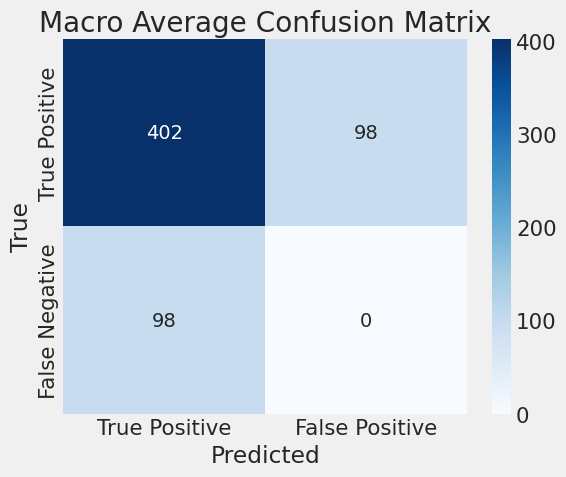

Classification Report:
              precision    recall  f1-score   support

    mountain       0.80      0.77      0.79       525
      street       0.77      0.79      0.78       501
     glacier       0.80      0.78      0.79       553
   buildings       0.78      0.69      0.73       437
         sea       0.76      0.81      0.79       510
      forest       0.91      0.97      0.94       474

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000



In [ ]:
# Extract true positives (TP) and false positives (FP) for each class
TP = np.diag(conf_matrix)
FP = conf_matrix.sum(axis=0) - TP
FN = conf_matrix.sum(axis=1) - TP

# Compute the macro average of TP and FP
macro_TP = np.mean(TP)
macro_FP = np.mean(FP)
macro_FN = np.mean(FN)

# Create a confusion matrix for the macro average
macro_conf_matrix = np.array([[macro_TP, macro_FP], [macro_FN, 0]])

# Plot the confusion matrix for the macro average
plt.figure(figsize=(6, 5))
sns.heatmap(macro_conf_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=['True Positive', 'False Positive'], yticklabels=['True Positive', 'False Negative'], annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Macro Average Confusion Matrix')
plt.tight_layout()
plt.show()

# Print the classification report
class_report = classification_report(y_true, y_pred, target_names=labels_dict.values())
print("Classification Report:")
print(class_report)

# Testing

In [ ]:
result = custom_cnn_model.predict_batch(test_dataset=test_dataset, labels_dict=labels_dict)
for i in np.unique(result, return_counts=True):
    print(i)

229/229 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step
['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
[5731  847  248  176  157  142]


# Save result

In [ ]:
# Save the entire model
custom_cnn_model.save(SAVE_PATH + 'custom_cnn_model.keras')

In [ ]:
# Save training history
with open(SAVE_PATH + 'training_history_1.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [ ]:
# Load model
loaded_model = load_model(SAVE_PATH + 'custom_cnn_model.keras')
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 148, 148, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 146, 146, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 146, 146, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 73, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 73, 73, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 71, 71, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 71, 71, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 69, 69, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 69, 69, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 69, 69, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 32, 32, 512)         │              

 Total params: 16,903,060 (64.48 MB)

 Trainable params: 5,633,158 (21.49 MB)

 Non-trainable params: 3,584 (14.00 KB)

 Optimizer params: 11,266,318 (42.98 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

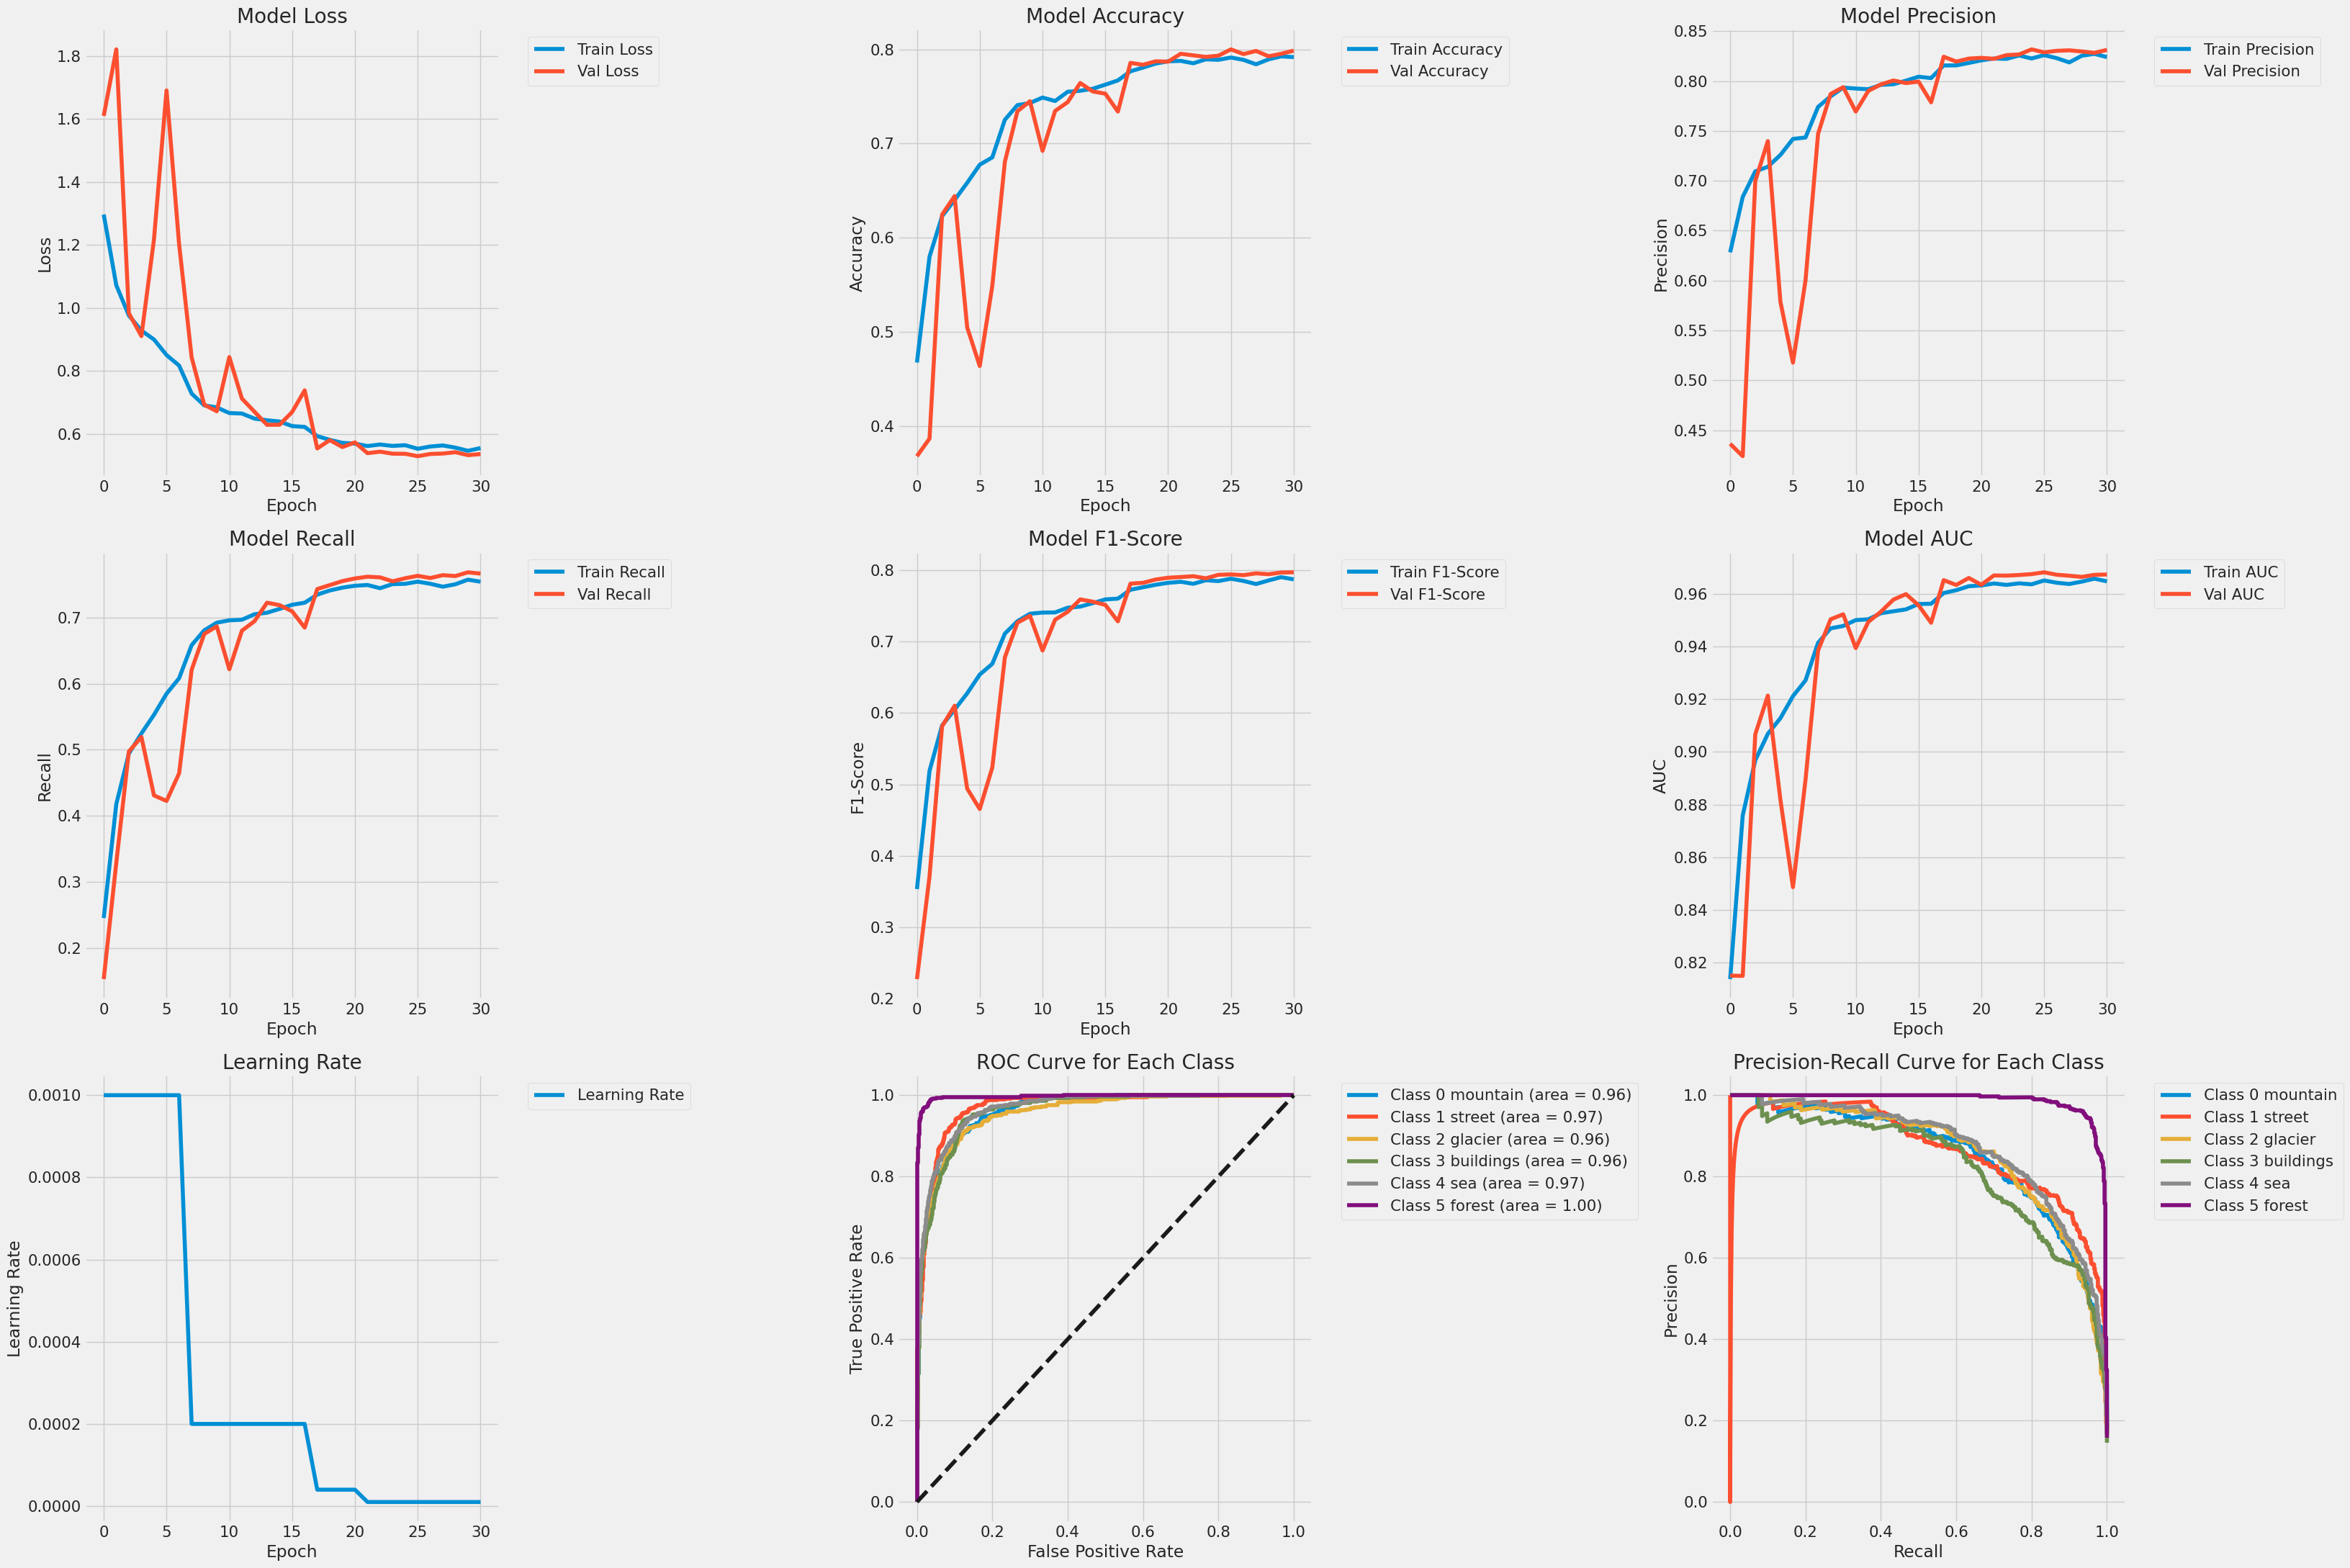

In [ ]:
# Open training history
with open(SAVE_PATH + 'training_history_1.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

model = CustomCNNModel(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.model = loaded_model
model.compile_model()
# Train the model for zero epochs to get an empty history object
empty_history = model.train(epochs=0)

# Set the loaded history to the empty history object
empty_history.history = loaded_history

# Now empty_history contains the loaded history
plot_metrics(empty_history, model=model)

# Hyperparameter tuning

In [ ]:
class CustomCNNHyperModel(kt.HyperModel):
    def __init__(self, input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=N_CLASSES):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()

        # First Convolutional Block
        model.add(Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
                         (3, 3), strides=(1, 1), input_shape=self.input_shape))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(hp.Int('conv1_filters', min_value=32, max_value=128, step=32),
                         (3, 3), strides=(1, 1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv1_dropout', min_value=0.2, max_value=0.5, step=0.1)))

        # Second Convolutional Block
        model.add(Conv2D(hp.Int('conv2_filters', min_value=64, max_value=256, step=64),
                         (3, 3), strides=(1, 1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(hp.Int('conv2_filters', min_value=64, max_value=256, step=64),
                         (3, 3), strides=(1, 1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv2_dropout', min_value=0.2, max_value=0.5, step=0.1)))

        # Third Convolutional Block
        model.add(Conv2D(hp.Int('conv3_filters', min_value=128, max_value=512, step=128),
                         (3, 3), strides=(1, 1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(hp.Int('conv3_filters', min_value=128, max_value=512, step=128),
                         (3, 3), strides=(1, 1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float('conv3_dropout', min_value=0.2, max_value=0.5, step=0.1)))

        # Global Average Pooling instead of Flattening
        model.add(GlobalAveragePooling2D())

        # Fully Connected Layer with Dropout
        model.add(Dense(hp.Int('dense_units', min_value=256, max_value=1024, step=256), activation='relu'))
        model.add(Dropout(hp.Float('dense_dropout', min_value=0.2, max_value=0.5, step=0.1)))
        model.add(Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'))

        # Output Layer for classification
        model.add(Dense(self.num_classes, activation='softmax'))  # Output layer with num_classes units

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='categorical_crossentropy',
                      metrics=[
                          'accuracy',  # Built-in accuracy for sparse labels
                          tf.keras.metrics.Precision(name='precision'),
                          tf.keras.metrics.Recall(name='recall'),
                          tf.keras.metrics.AUC(name='auc', multi_label=True),  # AUC for multiclass
                      ])
        return model

    def get_val_info(self, val_dataset=val_dataset):
        # Get true labels and predicted probabilities
        y_true = []
        y_pred_prob = []

        # Iterate through validation dataset and collect true labels and predicted probabilities
        for batch in val_dataset:
            x_val, y_val = batch  # x_val: validation features, y_val: validation true labels
            y_true.extend(y_val.numpy())  # Collect true labels

            # Predict the probabilities for each class
            preds = self.model.predict(x_val)
            y_pred_prob.extend(preds)

        # Convert lists to numpy arrays
        y_true = np.array(y_true)
        y_true = np.argmax(y_true, axis=-1)  # Convert one-hot encoded labels to categorical labels
        y_pred_prob = np.array(y_pred_prob)

        return {
            'y_true': y_true,  # Return true labels
            'y_pred_prob': y_pred_prob  # Return predicted probabilities
        }

# Create an instance of the hypermodel
hypermodel = CustomCNNHyperModel(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=N_CLASSES)

# Hyperparameter tuning with Hyperband
tuner = kt.Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=EPOCHS,
    factor=3,
    directory='hyperparameter_tuning',
    project_name='custom_cnn',
    overwrite=True
)

# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 9
conv1_filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv1_dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
conv2_filters (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
conv2_dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
conv3_filters (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': 'linear'}
conv3_dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 1024, 'step': 256, 'sampling': 'linear'}
dense_dropout (Float)
{'default': 0.2, 'conditions': [], 'min_v

In [ ]:
# Callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
checkpoint_callback = ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, 'best_custom_cnn_model.keras'), save_weights_only=False, monitor='val_loss', save_best_only=True, mode='min')
log_dir = os.path.join('logs', 'BestCustomCNN', 'fit', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Search for the best hyperparameters
tuner.search(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Display the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=N_TRIALS)[0]
print(best_hyperparameters.values)

Trial 90 Complete [00h 06m 31s]
val_accuracy: 0.7979999780654907

Best val_accuracy So Far: 0.8473333120346069
Total elapsed time: 04h 02m 38s
{'conv1_filters': 96, 'conv1_dropout': 0.2, 'conv2_filters': 192, 'conv2_dropout': 0.2, 'conv3_filters': 256, 'conv3_dropout': 0.4, 'dense_units': 256, 'dense_dropout': 0.30000000000000004, 'learning_rate': 0.00030032086079758493, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0047'}


# Hypermodel Training

In [ ]:
# Train the model with the best hyperparameters
history_best = best_model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[early_stopping, reduce_lr, checkpoint_callback, tensorboard_callback])

Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - accuracy: 0.8172 - auc: 0.9716 - loss: 0.4911 - precision: 0.8414 - recall: 0.7906 - val_accuracy: 0.7400 - val_auc: 0.9472 - val_loss: 0.7150 - val_precision: 0.7940 - val_recall: 0.6963 - learning_rate: 3.0032e-04
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.8103 - auc: 0.9700 - loss: 0.5059 - precision: 0.8382 - recall: 0.7802 - val_accuracy: 0.7590 - val_auc: 0.9652 - val_loss: 0.6289 - val_precision: 0.7935 - val_recall: 0.7200 - learning_rate: 3.0032e-04
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.8182 - auc: 0.9724 - loss: 0.4863 - precision: 0.8433 - recall: 0.7931 - val_accuracy: 0.7857 - val_auc: 0.9671 - val_loss: 0.5790 - val_precision: 0.8117 - val_recall: 0.7617 - learning_rate: 3.0032e-04
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.8238 - auc: 0.9730 - loss: 0.4812 - precision: 0.8475 - recall: 0.7952 - val_accuracy: 0.6663 - val_auc: 0.9444 - va

In [ ]:
def plot_metrics(history):
    # Extract metrics from the history object
    metrics = {
        'loss': history.history.get('loss', []),
        'val_loss': history.history.get('val_loss', []),
        'precision': history.history.get('precision', []),
        'val_precision': history.history.get('val_precision', []),
        'recall': history.history.get('recall', []),
        'val_recall': history.history.get('val_recall', []),
        'auc': history.history.get('auc', []),
        'val_auc': history.history.get('val_auc', []),
        'lr': history.history.get('learning_rate', []),
        'accuracy': history.history.get('accuracy', []),
        'val_accuracy': history.history.get('val_accuracy', []),
    }

    # Calculate F1-score for each epoch (if precision and recall are available)
    metrics['f1_score'] = [2 * ((p * r) / (p + r + 1e-7)) if (p + r) > 0 else 0
                           for p, r in zip(metrics['precision'], metrics['recall'])]
    metrics['val_f1_score'] = [2 * ((p * r) / (p + r + 1e-7)) if (p + r) > 0 else 0
                               for p, r in zip(metrics['val_precision'], metrics['val_recall'])]

    epochs = range(1, len(metrics['loss']) + 1)

    plt.figure(figsize=(33, 22))

    # Plot Loss
    plt.subplot(3, 3, 1)
    plt.plot(metrics['loss'], label='Train Loss')
    plt.plot(metrics['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot Accuracy
    plt.subplot(3, 3, 2)
    plt.plot(metrics['accuracy'], label='Train Accuracy')
    plt.plot(metrics['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot Precision
    plt.subplot(3, 3, 3)
    plt.plot(metrics['precision'], label='Train Precision')
    plt.plot(metrics['val_precision'], label='Val Precision')
    plt.title('Model Precision')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot Recall
    plt.subplot(3, 3, 4)
    plt.plot(metrics['recall'], label='Train Recall')
    plt.plot(metrics['val_recall'], label='Val Recall')
    plt.title('Model Recall')
    plt.ylabel('Recall')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot F1-score
    plt.subplot(3, 3, 5)
    plt.plot(metrics['f1_score'], label='Train F1-Score')
    plt.plot(metrics['val_f1_score'], label='Val F1-Score')
    plt.title('Model F1-Score')
    plt.ylabel('F1-Score')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot AUC
    plt.subplot(3, 3, 6)
    plt.plot(metrics['auc'], label='Train AUC')
    plt.plot(metrics['val_auc'], label='Val AUC')
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Plot learning rate
    plt.subplot(3, 3, 7)
    plt.plot(metrics['lr'], label='Learning Rate')
    plt.title('Learning Rate')
    plt.ylabel('Learning Rate')
    plt.xlabel('Epoch')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

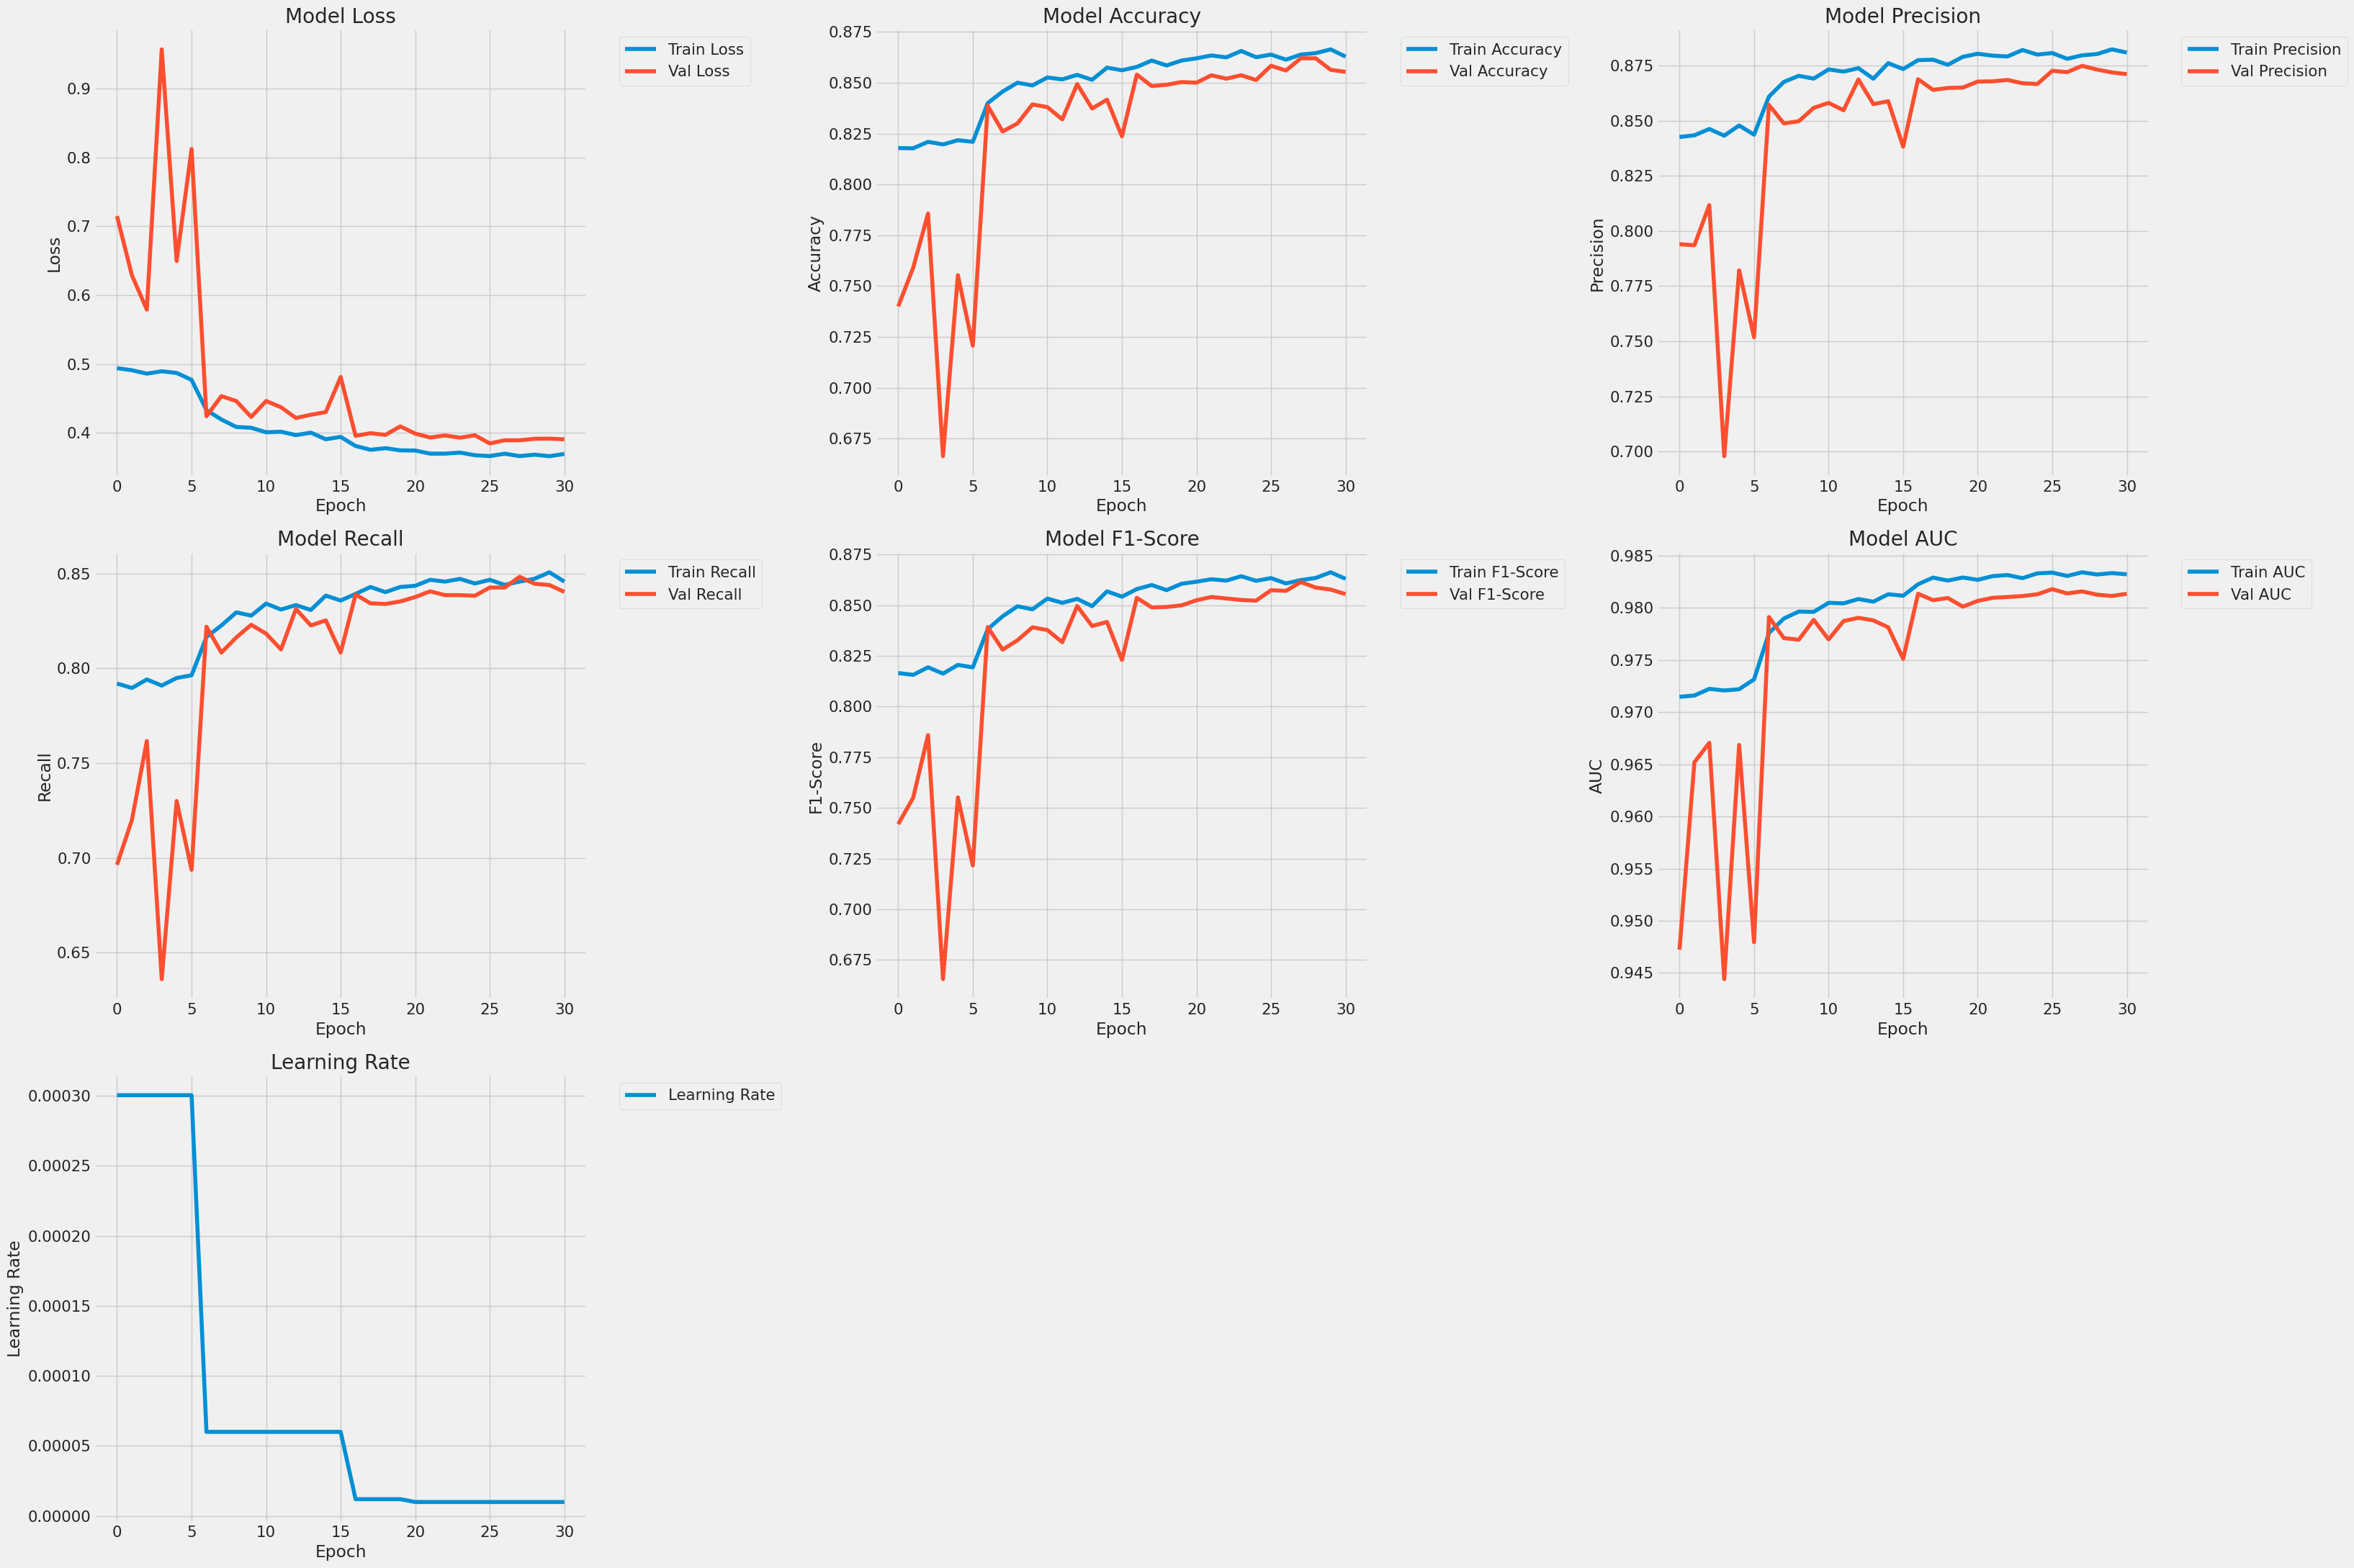

In [ ]:
plot_metrics(history_best)

In [ ]:
# Evaluate the best model
result = best_model.evaluate(val_dataset)
loss, accuracy, precision, recall, auc = result
print(f'Validation Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, AUC: {auc:.4f}')

94/94 ━━━━━━━━━━━━━━━━━━━━ 70s 690ms/step - accuracy: 0.8574 - auc: 0.9804 - loss: 0.3972 - precision: 0.8705 - recall: 0.8473
Validation Loss: 0.3859, Accuracy: 0.8587, Precision: 0.8730, Recall: 0.8457, AUC: 0.9814


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

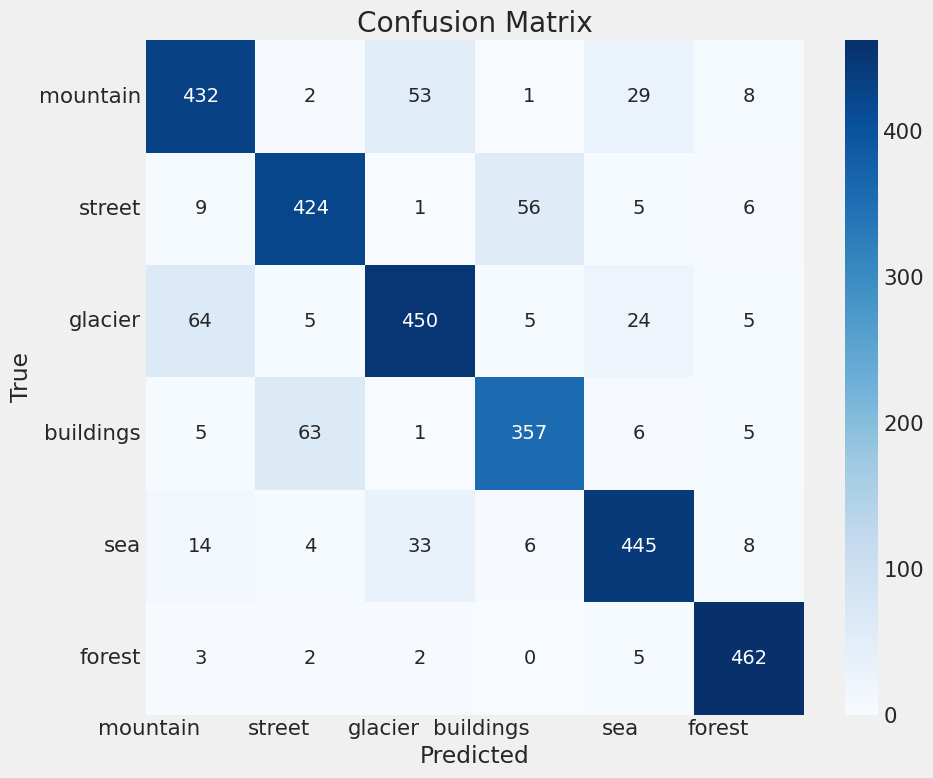

Classification Report:
              precision    recall  f1-score   support

    mountain       0.82      0.82      0.82       525
      street       0.85      0.85      0.85       501
     glacier       0.83      0.81      0.82       553
   buildings       0.84      0.82      0.83       437
         sea       0.87      0.87      0.87       510
      forest       0.94      0.97      0.95       474

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



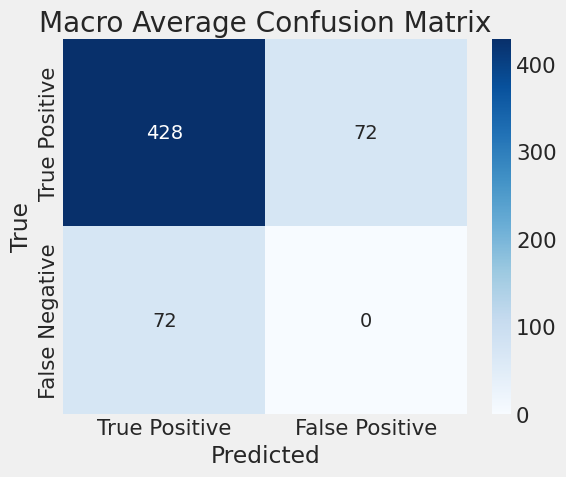

Classification Report:
              precision    recall  f1-score   support

    mountain       0.82      0.82      0.82       525
      street       0.85      0.85      0.85       501
     glacier       0.83      0.81      0.82       553
   buildings       0.84      0.82      0.83       437
         sea       0.87      0.87      0.87       510
      forest       0.94      0.97      0.95       474

    accuracy                           0.86      3000
   macro avg       0.86      0.86      0.86      3000
weighted avg       0.86      0.86      0.86      3000



In [ ]:
def get_conf_matrix(model=best_model, val_dataset=val_dataset, labels_dict=labels_dict):
    y_true = []
    y_pred_prob = []

    # Iterate through validation dataset and collect true labels and predicted probabilities
    for batch in val_dataset:
        x_val, y_val = batch  # x_val: validation features, y_val: validation true labels
        y_true.extend(y_val.numpy())  # Collect true labels

        # Predict the probabilities for each class
        preds = best_model.predict(x_val)
        y_pred_prob.extend(preds)

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_true = np.argmax(y_true, axis=-1)  # Convert one-hot encoded labels to categorical labels
    y_pred_prob = np.array(y_pred_prob)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Print the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))  # Increase the figure size
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels_dict.values(), yticklabels=labels_dict.values(), annot_kws={"size": 14})  # Increase annotation font size
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(ha='right')  # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Print the classification report
    class_report = classification_report(y_true, y_pred, target_names=labels_dict.values())
    print("Classification Report:")
    print(class_report)

    # Extract true positives (TP) and false positives (FP) for each class
    TP = np.diag(conf_matrix)
    FP = conf_matrix.sum(axis=0) - TP
    FN = conf_matrix.sum(axis=1) - TP

    # Compute the macro average of TP and FP
    macro_TP = np.mean(TP)
    macro_FP = np.mean(FP)
    macro_FN = np.mean(FN)

    # Create a confusion matrix for the macro average
    macro_conf_matrix = np.array([[macro_TP, macro_FP], [macro_FN, 0]])

    # Plot the confusion matrix for the macro average
    plt.figure(figsize=(6, 5))
    sns.heatmap(macro_conf_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=['True Positive', 'False Positive'], yticklabels=['True Positive', 'False Negative'], annot_kws={"size": 14})
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Macro Average Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Print the classification report
    class_report = classification_report(y_true, y_pred, target_names=labels_dict.values())
    print("Classification Report:")
    print(class_report)

get_conf_matrix(model=best_model, val_dataset=val_dataset, labels_dict=labels_dict)

# Hypermodel Testing

In [ ]:
result = best_model.predict(test_dataset)
result = np.argmax(result, axis=1)
result = [labels_dict[x] for x in result]
for i in np.unique(result, return_counts=True):
    print(i)

229/229 ━━━━━━━━━━━━━━━━━━━━ 158s 694ms/step
['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
[3043  766  493 1281  954  764]


# Save best cnn result

In [ ]:
# Save the dictionary to a file
with open(SAVE_PATH + 'best_hyperparameters.pkl', 'wb') as file:
    pickle.dump(best_hyperparameters.values, file)

In [ ]:
# Save the entire model
best_model.save(SAVE_PATH + 'best_custom_cnn_model.keras')

In [ ]:
# Save the training history
with open(SAVE_PATH + 'training_history_best.pkl', 'wb') as file:
    pickle.dump(history_best.history, file)

In [ ]:
# Load the hyper model
loaded_best_model = load_model(SAVE_PATH + 'best_custom_cnn_model.keras')
loaded_best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 96)   │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 148, 148, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 96)   │        83,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 146, 146, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 146, 146, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 73, 73, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 192)    │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 71, 71, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 71, 71, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 69, 69, 192)    │       331,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 69, 69, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 69, 69, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 34, 34, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       442,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 30, 30, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 30, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 30, 30, 256)    │             

 Total params: 5,257,524 (20.06 MB)

 Trainable params: 1,751,782 (6.68 MB)

 Non-trainable params: 2,176 (8.50 KB)

 Optimizer params: 3,503,566 (13.37 MB)

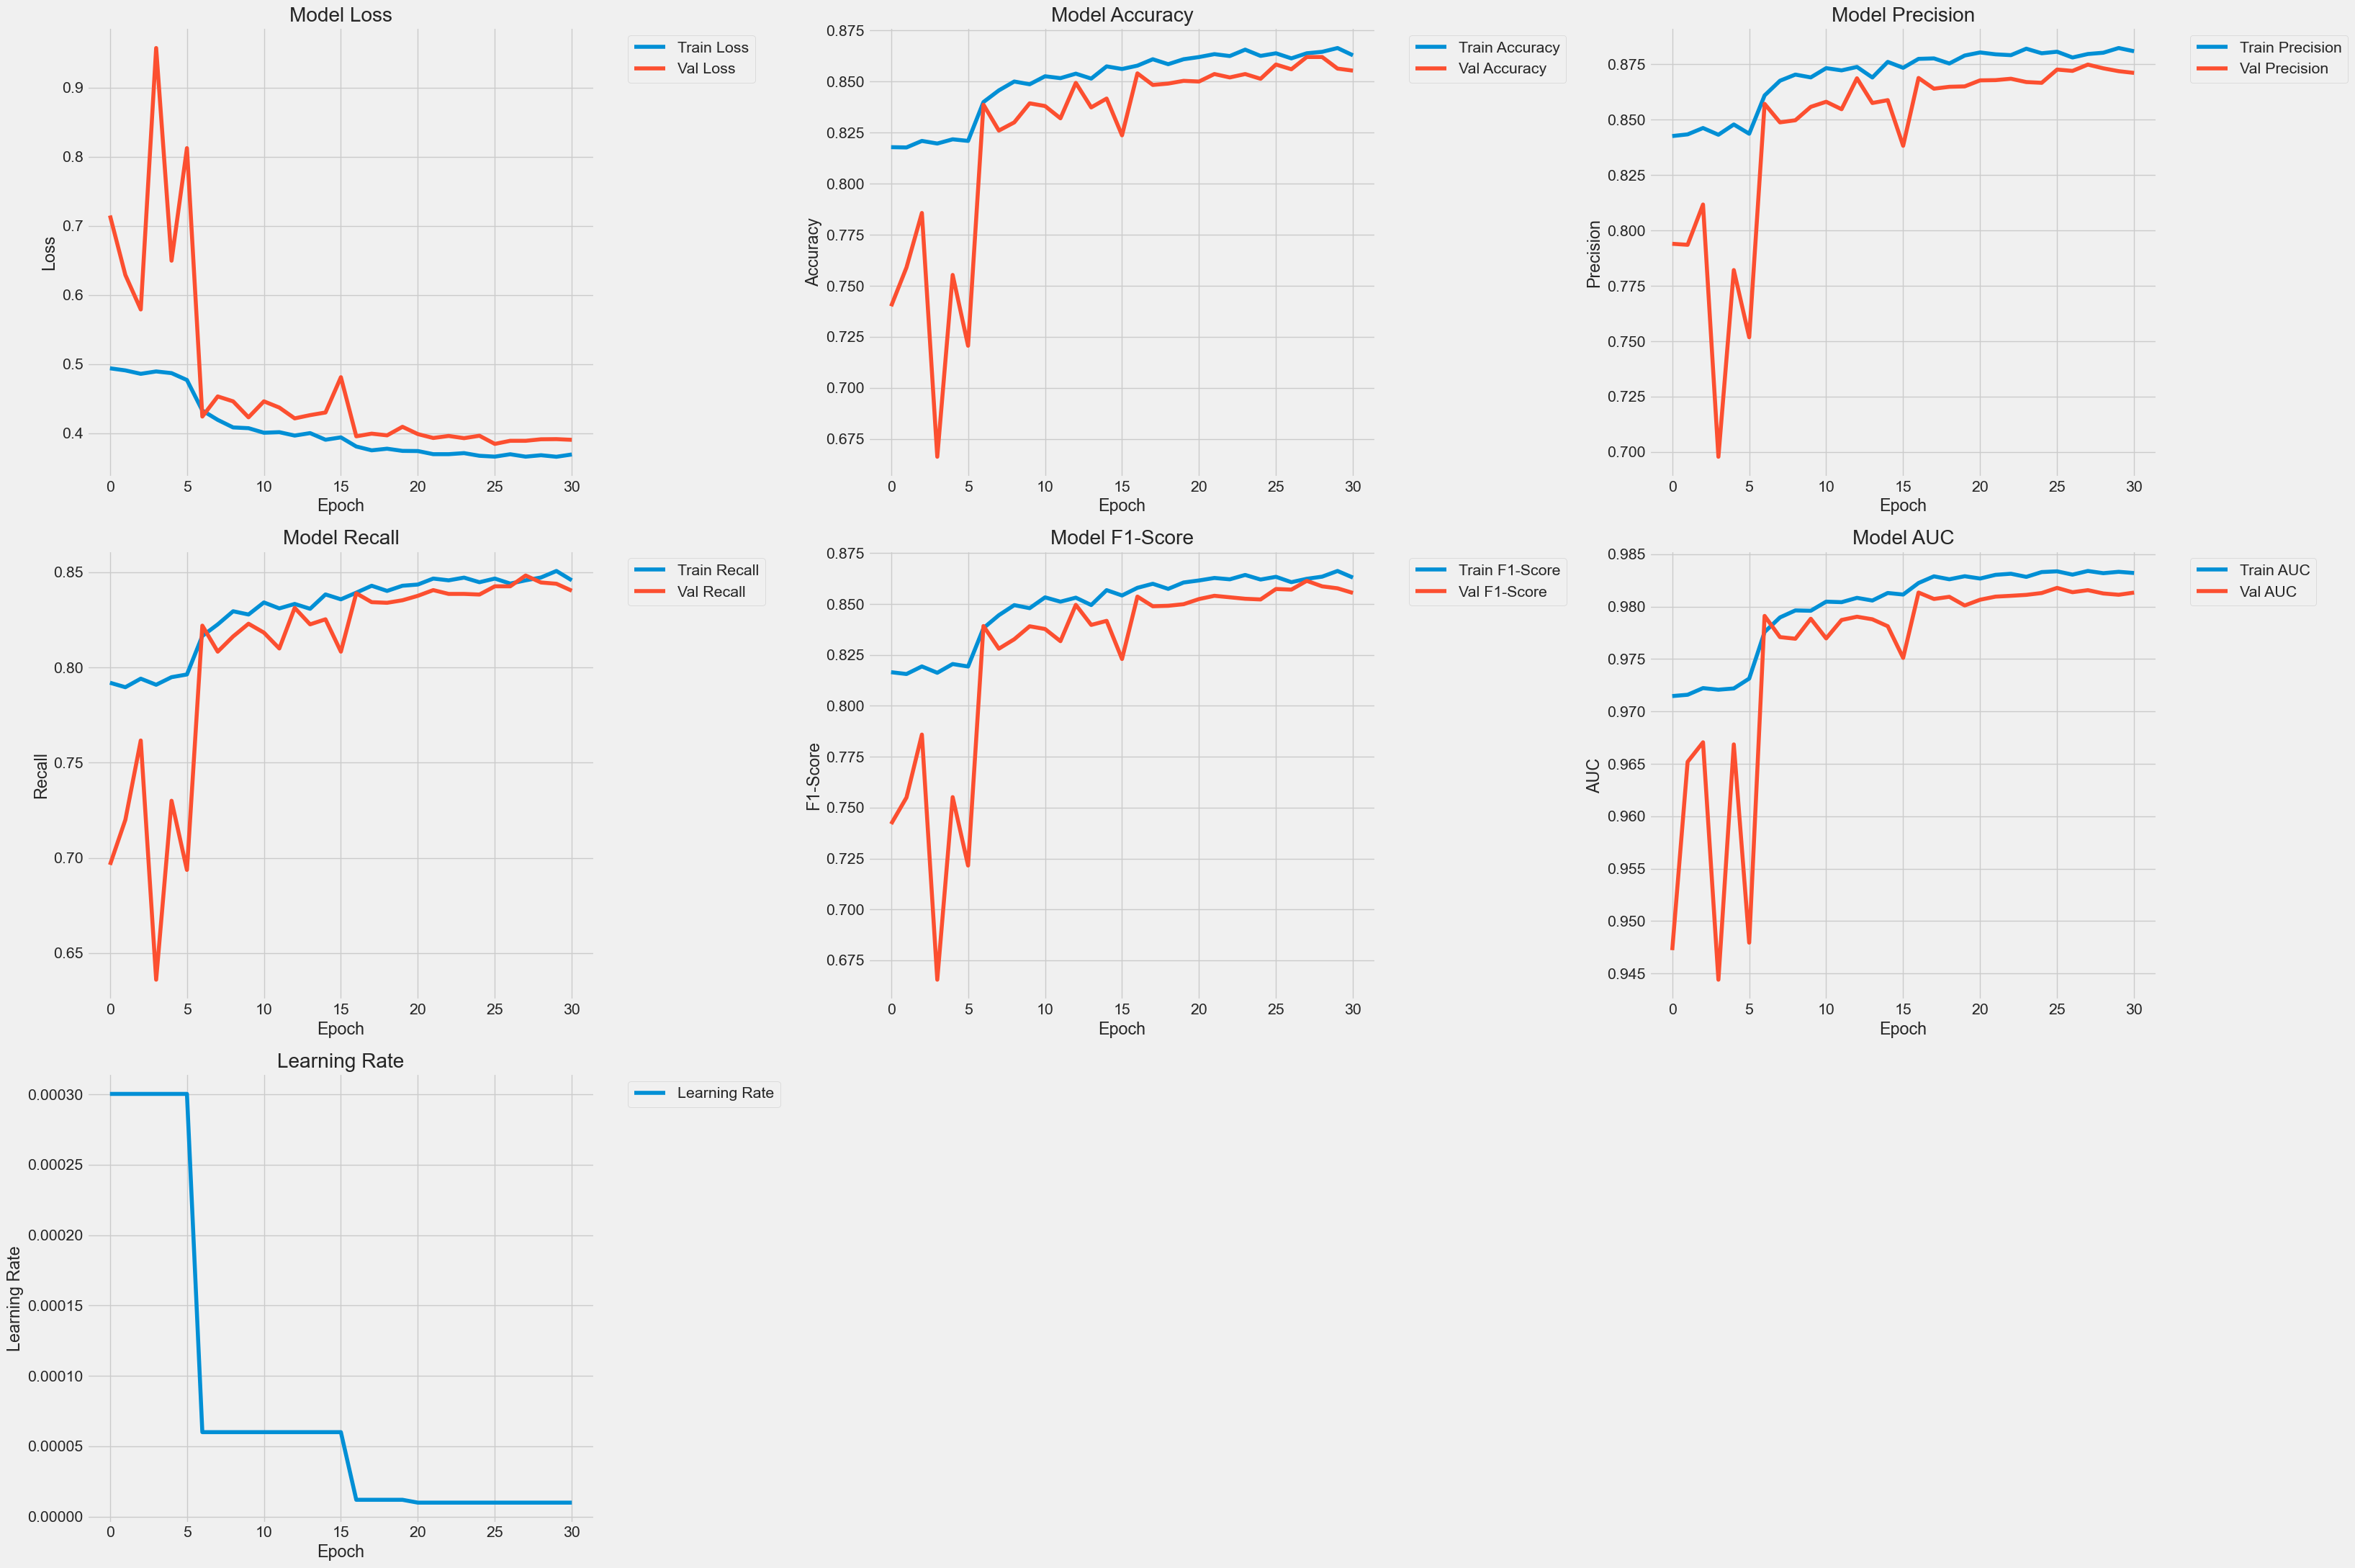

In [ ]:
# Load the training history
with open(SAVE_PATH + 'training_history_best.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

model = CustomCNNModel(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.model = loaded_best_model
model.compile_model()
# Create an empty history object
empty_history = model.train(train_dataset, val_dataset=val_dataset, epochs=0)

# Set the loaded history to the empty history object
empty_history.history = loaded_history

# Now empty_history contains the loaded history
plot_metrics(empty_history)

# Error analysis

In [6]:
data = np.load(ARR_PATH, allow_pickle=True)
X_train, X_val, Y_train, Y_val, X_test, labels_dict = data['X_train'], data['X_val'], data['Y_train'], data['Y_val'], data['X_test'], data['labels_dict']
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape, X_test.shape)
labels_dict = labels_dict.tolist()
labels_dict = {v: k for k, v in labels_dict.items()}
labels_dict

(14034, 150, 150, 3) (3000, 150, 150, 3) (14034,) (3000,) (7301, 150, 150, 3)


{0: 'mountain',
 1: 'street',
 2: 'glacier',
 3: 'buildings',
 4: 'sea',
 5: 'forest'}

In [7]:
# Define a function to apply random transformations to images
def random_transform(image, label):
    image = tf.image.random_flip_left_right(image)  # Randomly flip the image horizontally
    image = tf.image.random_flip_up_down(image)  # Randomly flip the image vertically
    image = tf.image.random_brightness(image, max_delta=0.1)  # Randomly change the brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Randomly change the contrast
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)  # Randomly change the saturation
    image = tf.image.random_hue(image, max_delta=0.1)  # Randomly change the hue
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Randomly rotate the image
    image = tf.image.random_crop(image, size=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3])  # Randomly crop the image

    # Random zoom
    scales = list(np.arange(0.8, 1.0, 0.1))
    boxes = np.zeros((len(scales), 4))
    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[i] = [x1, y1, x2, y2]

    def random_zoom(image):
        crops = tf.image.crop_and_resize([image], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=IMAGE_SIZE)
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    image = random_zoom(image)

    # Random Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    image = tf.add(image, noise)

    return image, label

# Function to cast images and labels to float16
def cast_to_float16(image, label):
    image = tf.cast(image, tf.float16)
    label = tf.cast(label, tf.float16)
    return image, label

def create_dataset(X, Y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    # dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.map(random_transform, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(cast_to_float16, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
# Load the dictionary from the file
with open(SAVE_PATH + 'best_hyperparameters.pkl', 'rb') as file:
    loaded_hyperparameters = pickle.load(file)

print(loaded_hyperparameters)

{'conv1_filters': 96, 'conv1_dropout': 0.2, 'conv2_filters': 192, 'conv2_dropout': 0.2, 'conv3_filters': 256, 'conv3_dropout': 0.4, 'dense_units': 256, 'dense_dropout': 0.30000000000000004, 'learning_rate': 0.00030032086079758493, 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0047'}


In [8]:
loaded_model = load_model(SAVE_PATH + 'best_custom_cnn_model.keras')
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 96)        │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 96)        │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 148, 148, 96)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 146, 146, 96)        │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 146, 146, 96)        │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 146, 146, 96)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 73, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 73, 73, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 71, 71, 192)         │         166,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 71, 71, 192)         │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 71, 71, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 69, 69, 192)         │         331,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 69, 69, 192)         │             768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 69, 69, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 34, 34, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 34, 34, 192)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 256)         │         442,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 32, 32, 256)         │              

 Total params: 5,257,524 (20.06 MB)

 Trainable params: 1,751,782 (6.68 MB)

 Non-trainable params: 2,176 (8.50 KB)

 Optimizer params: 3,503,566 (13.37 MB)

In [9]:
X_val_transformed = np.array([random_transform(image, label)[0].numpy() for image, label in zip(X_val, Y_val)])
X_val_transformed = tf.cast(X_val_transformed, tf.float16).numpy()

In [10]:
result = loaded_model.predict(X_val_transformed)
result = np.argmax(result, axis=1)
result

94/94 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step


array([0, 5, 2, ..., 3, 1, 3])

In [11]:
ans = [labels_dict[x] for x in Y_val]
for i in np.unique(ans, return_counts=True):
    print(i)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
[437 474 553 525 510 501]


In [12]:
result2 = [labels_dict[x] for x in result]
for i in np.unique(result2, return_counts=True):
    print(i)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']
[420 497 546 529 503 505]


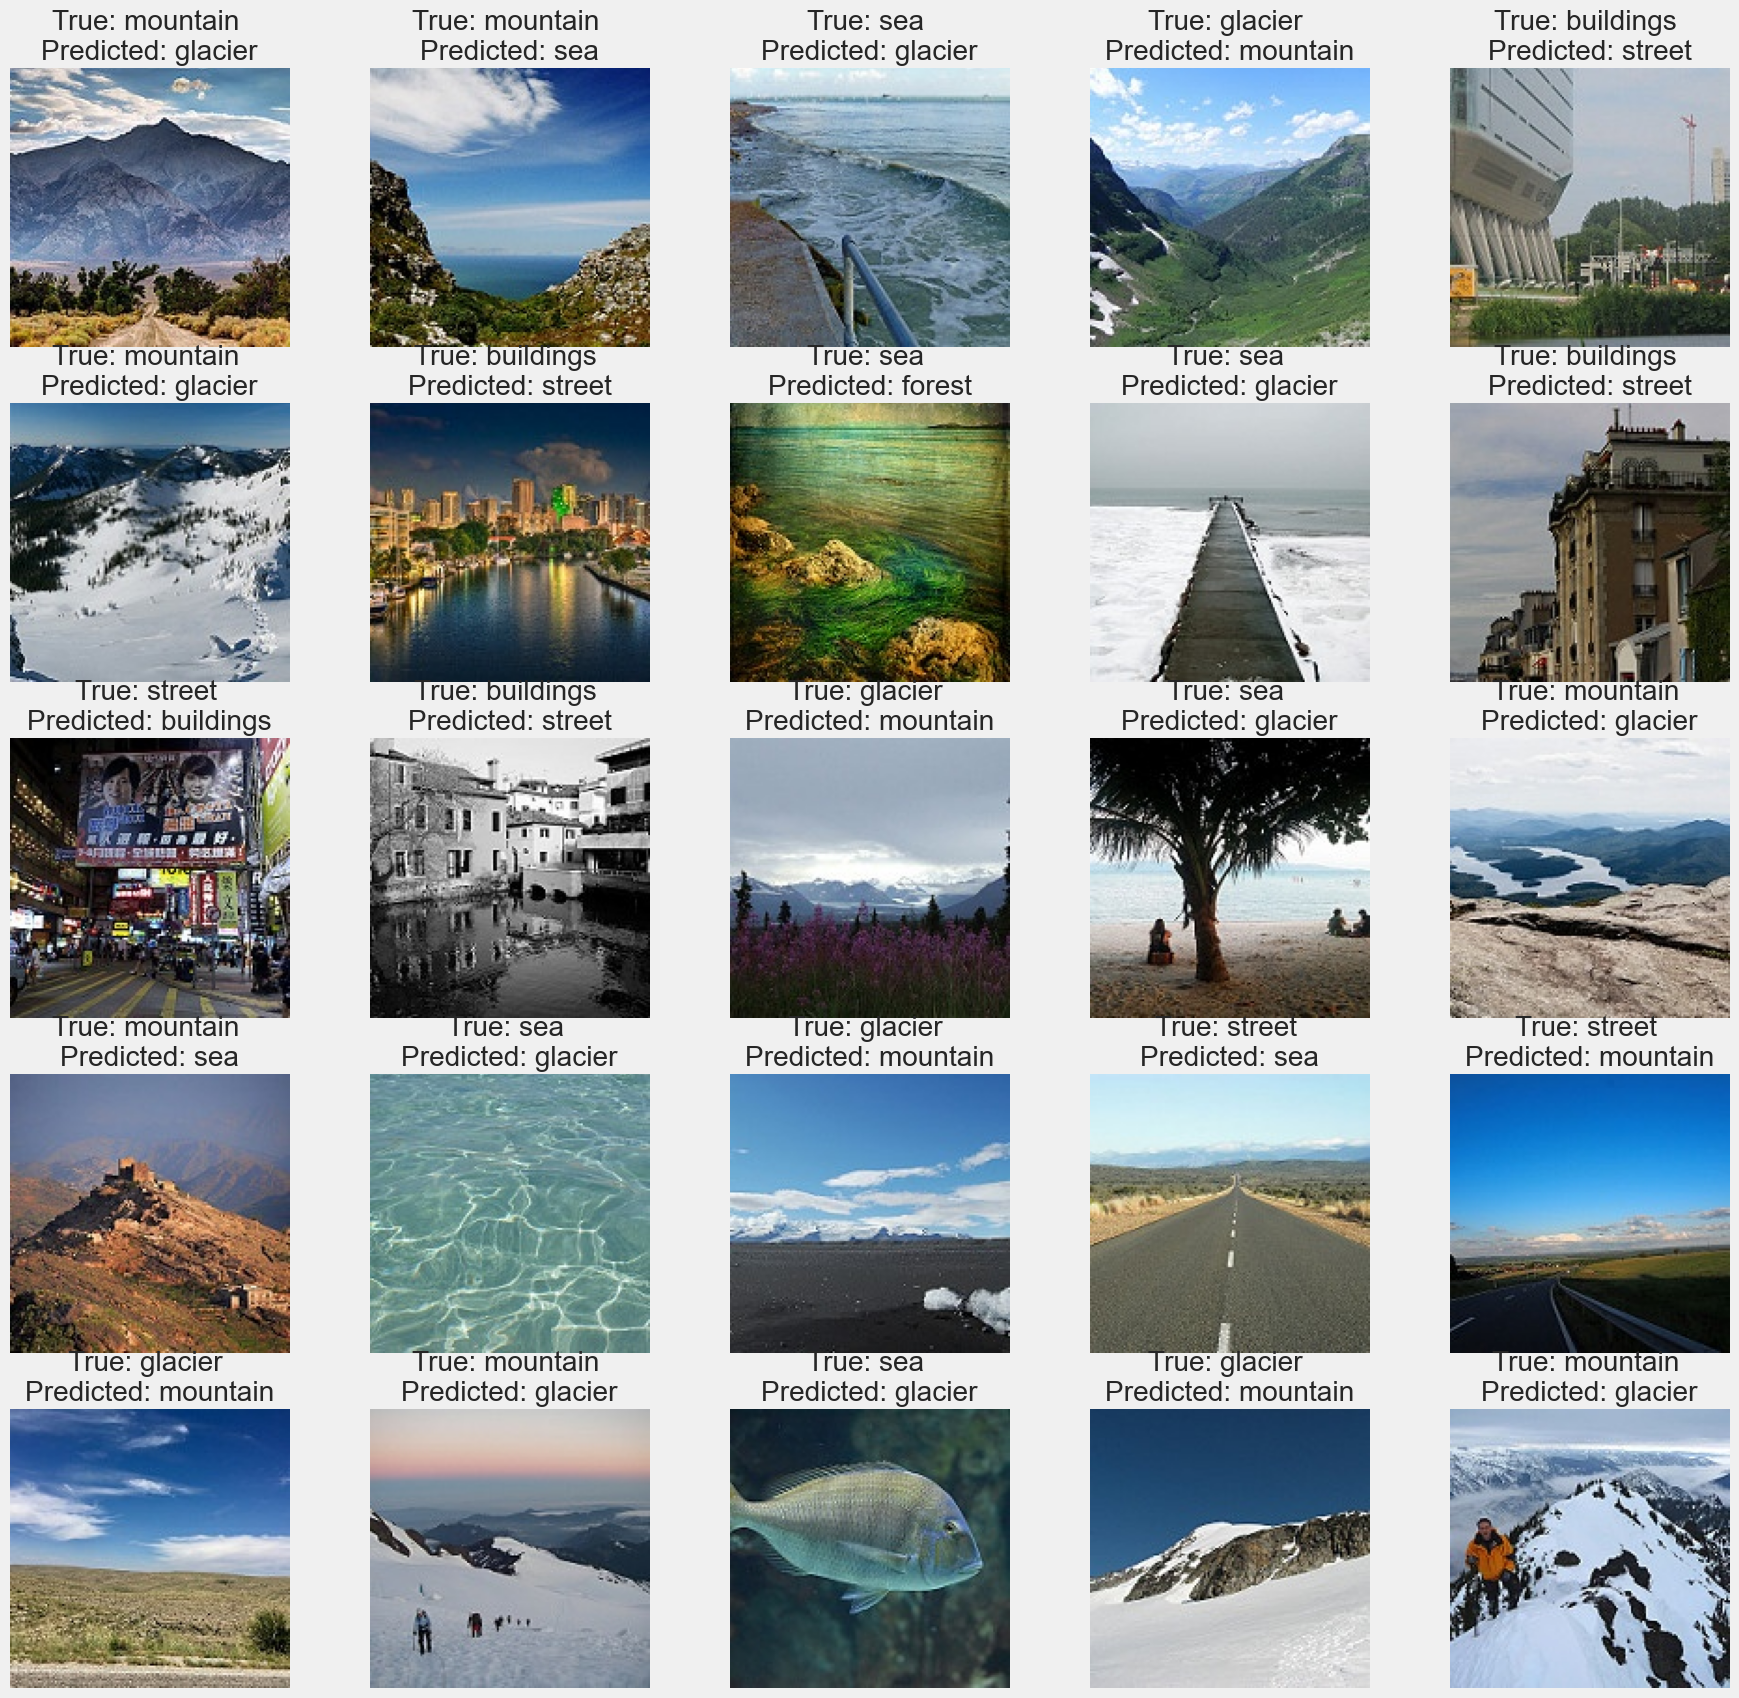

In [ ]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels, num=25):
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    plt.figure(figsize=(20, 20))
    for i in range(len(mislabeled_indices[0])):
        if i >= num:
            break
        plt.subplot(5, 5, i + 1)
        plt.imshow(mislabeled_images[i])
        plt.title(f'True: {class_names[test_labels[mislabeled_indices][i]]} \nPredicted: {class_names[mislabeled_labels[i]]}')
        plt.axis('off')

print_mislabeled_images(labels_dict, X_val, Y_val, result) # maximum printing out 25 images


Confusion Matrix:
[[431   0  61   2  22   9]
 [  7 427   2  54   7   4]
 [ 69   2 447   5  23   7]
 [  5  68   1 353   5   5]
 [ 15   6  33   6 441   9]
 [  2   2   2   0   5 463]]


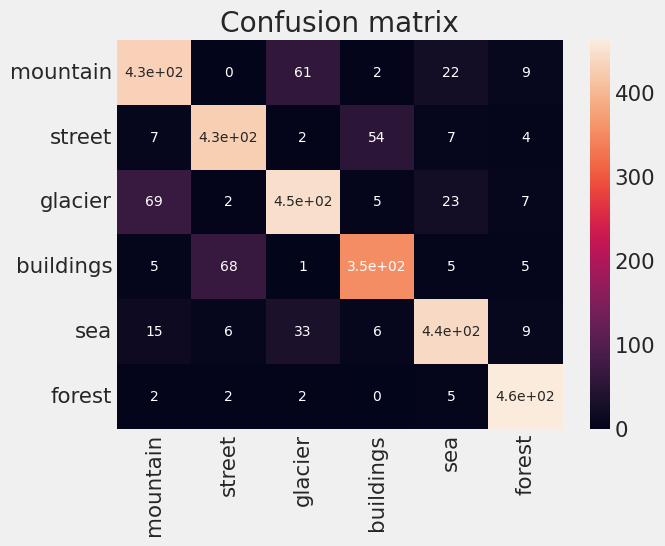

In [13]:
CM = confusion_matrix(Y_val, result)
print("Confusion Matrix:")
print(CM)
ax = plt.axes()
sns.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels=labels_dict.values(),
           yticklabels=labels_dict.values(), ax = ax)
ax.set_title('Confusion matrix')
plt.show()

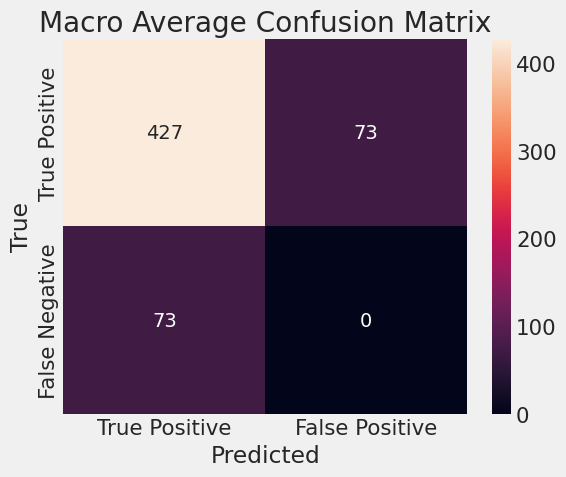

Classification Report:
              precision    recall  f1-score   support

    mountain       0.81      0.82      0.82       525
      street       0.85      0.85      0.85       501
     glacier       0.82      0.81      0.81       553
   buildings       0.84      0.81      0.82       437
         sea       0.88      0.86      0.87       510
      forest       0.93      0.98      0.95       474

    accuracy                           0.85      3000
   macro avg       0.85      0.86      0.85      3000
weighted avg       0.85      0.85      0.85      3000



In [14]:
# Extract true positives (TP) and false positives (FP) for each class
TP = np.diag(CM)
FP = CM.sum(axis=0) - TP
FN = CM.sum(axis=1) - TP

# Compute the macro average of TP and FP
macro_TP = np.mean(TP)
macro_FP = np.mean(FP)
macro_FN = np.mean(FN)

# Create a confusion matrix for the macro average
macro_CM = np.array([[macro_TP, macro_FP], [macro_FN, 0]])

# Plot the confusion matrix for the macro average
plt.figure(figsize=(6, 5))
sns.heatmap(macro_CM, annot=True, fmt='.0f', xticklabels=['True Positive', 'False Positive'], yticklabels=['True Positive', 'False Negative'], annot_kws={"size": 14})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Macro Average Confusion Matrix')
plt.tight_layout()
plt.show()

# Print the classification report
class_report = classification_report(Y_val, result, target_names=labels_dict.values())
print("Classification Report:")
print(class_report)

# Other Image Testing

In [ ]:
import os, sys, json, cv2, time, glob, gc, datetime, pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.patches as patches
import seaborn as sns; sns.set(font_scale=1.4)
import keras_tuner as kt
import warnings

from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Reshape, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.regularizers import l1, l2, l1_l2
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_score, recall_score, roc_auc_score, f1_score, precision_recall_curve, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from kerastuner import HyperModel, Hyperband
from kerastuner.tuners import RandomSearch
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

/var/folders/nv/cddx4y_s46n_4yhxp7v2bb540000gn/T/ipykernel_62279/70600251.py:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel, Hyperband


In [ ]:
# Define a function to apply random transformations to images
def random_transform(image, label):
    image = tf.image.random_flip_left_right(image)  # Randomly flip the image horizontally
    image = tf.image.random_flip_up_down(image)  # Randomly flip the image vertically
    image = tf.image.random_brightness(image, max_delta=0.1)  # Randomly change the brightness
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # Randomly change the contrast
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)  # Randomly change the saturation
    image = tf.image.random_hue(image, max_delta=0.1)  # Randomly change the hue
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  # Randomly rotate the image
    image = tf.image.random_crop(image, size=[150, 150, 3])  # Randomly crop the image

    # Random zoom
    scales = list(np.arange(0.8, 1.0, 0.1))
    boxes = np.zeros((len(scales), 4))
    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[i] = [x1, y1, x2, y2]

    def random_zoom(image):
        crops = tf.image.crop_and_resize([image], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(150, 150))
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    image = random_zoom(image)

    # Random Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32)
    image = tf.add(image, noise)

    return image, label

# Function to cast images and labels to float16
def cast_to_float16(image, label):
    image = tf.cast(image, tf.float16)
    label = tf.cast(label, tf.float16)
    return image, label

def create_dataset(X, Y, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    # dataset = dataset.shuffle(buffer_size=len(X))
    dataset = dataset.map(random_transform, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(cast_to_float16, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
data = np.load('./natural_scene_data.npz', allow_pickle=True)
labels_dict = data['labels_dict']
labels_dict = labels_dict.tolist()
labels_dict = {v: k for k, v in labels_dict.items()}
labels_dict

{0: 'mountain',
 1: 'street',
 2: 'glacier',
 3: 'buildings',
 4: 'sea',
 5: 'forest'}

In [ ]:
img_path = './apu.png'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (150, 150))

# Append the image and its corresponding label to the lists
image = image / 255.0 # Normalize the pixel values, data scaling
image.shape

(150, 150, 3)

In [ ]:
loaded_model = load_model('models/CustomCNN/' + 'best_custom_cnn_model.keras')

In [ ]:
image_transformed = np.array(random_transform(image, 0)[0].numpy())
image_transformed = tf.cast(image_transformed, tf.float16).numpy()
image_transformed = np.expand_dims(image_transformed, axis=0)
image_transformed.shape

(1, 150, 150, 3)

In [ ]:
result = loaded_model.predict(image_transformed)
result_class = np.argmax(result, axis=1)
print(result_class)
result_class = labels_dict[result_class[0]]
result_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[3]


'buildings'

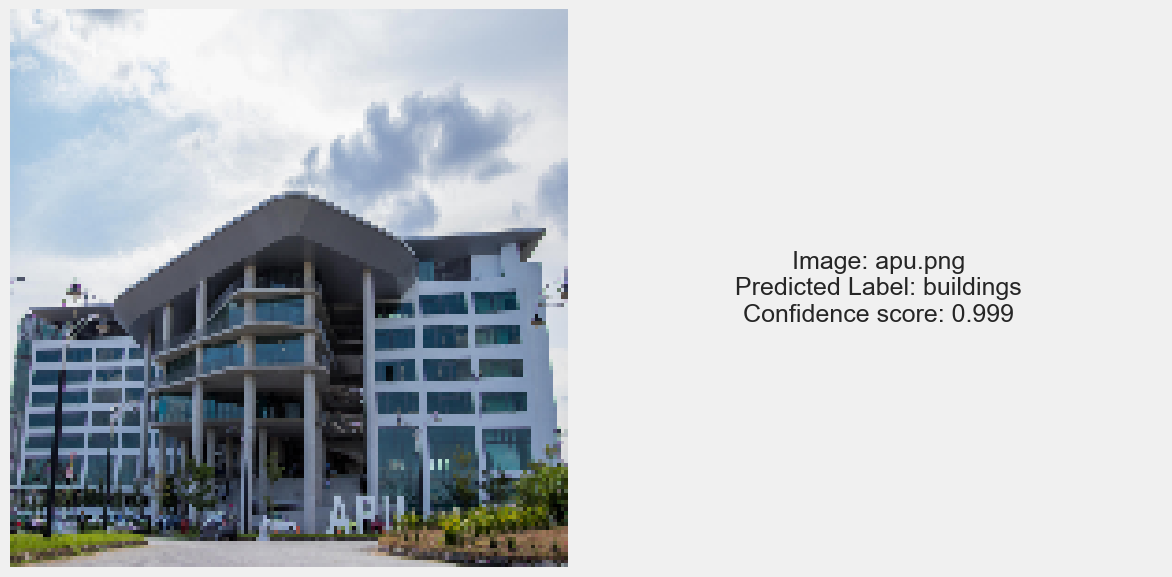

In [ ]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the image in the left subplot
ax1.imshow(image)
ax1.axis('off')  # Turn off the axis for the image

# Add the text annotation in the right subplot
textstr = f'''
Image: {img_path.split('/')[-1]}
Predicted Label: {result_class}
Confidence score: {np.max(result):.3f}
'''
ax2.text(0.5, 0.5, textstr, fontsize=18, va='center', ha='center')
ax2.axis('off')  # Turn off the axis for the text

# Adjust layout
plt.tight_layout()
plt.show()